# Simulating reviewing with synthetic priors

## Loading packages and importing dataset

In [166]:
import asreview
import pandas as pd
from asreview.models.balancers import Balanced
from asreview.models.classifiers import SVM
from asreview.models.feature_extractors import Tfidf
from asreview.models.queriers import Max
import numpy as np
import random
from matplotlib import pyplot as plt
import pathlib as Path
import os
import math
from dotenv import load_dotenv
import dspy
from openai import OpenAI
import litellm


In [ ]:
name_dataset = 'Brouwer_2019'

dataset_path = f'C:\\Users\\timov\\Desktop\\Utrecht\\Utrecht\\MSBBSS\\thesis_timo\\Synergy\\synergy_dataset\\{name_dataset}.csv'
output_path = output_path = os.path.join(os.getcwd(), name_dataset)
stimulus_for_llm = ['inclusion_criteria', 'exclusion_criteria'] # specify which columns from the snyergy metadata to use as stimulus for LLM

In [182]:
os.makedirs(output_path, exist_ok=True)
print("Directory created at:", output_path)

Directory created at: c:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\notebooks\Brouwer_2019


In [183]:
dataset = pd.read_csv(dataset_path)
len(dataset)

38114

## Generating and selecting priors

### Importing research specific stimulus

In [187]:
synergy_metadata = pd.read_excel(r'C:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\Synergy\synergy_dataset_overview.xlsx')

np.where(synergy_metadata['dataset_ID'].to_numpy() == name_dataset)

row_of_dataset = synergy_metadata.index[synergy_metadata['dataset_ID'].eq(name_dataset)]

int_of_row = int(row_of_dataset[0])

criteria = synergy_metadata.loc[int_of_row, stimulus_for_llm]
criteria

inclusion_criteria    Criteria for studies to be included in the rev...
exclusion_criteria    Studies that solely included people with a fir...
Name: 2, dtype: object

### Generating synthetic priors

In [7]:
load_dotenv()  # Load environment variables from .env file

lm = dspy.LM("openai/gpt-4o-mini", temperature=0.7)
dspy.configure(lm=lm)

class MakeAbstract(dspy.Signature):
    """Generate a fake abstract based on search terms and whether it should be included or not."""
    criteria: str = dspy.InputField(desc="The inclusion or exclusion criteria of the review")
    label_included: int = dspy.InputField(desc="1 if it would perfectly fit the review; 0 if it would be returned by the given search terms but not fit the review")
    nonce: str = dspy.InputField() 
    jsonl: str = dspy.OutputField(desc='One-line JSON object: {"doi":"None","title":"...","abstract":"...","label_included":"1/0","reasoning":"..."}')

make_abstract = dspy.ChainOfThought(MakeAbstract)

In [8]:
df_generated = pd.DataFrame()
n_abstracts = 5

# loop to generate multiple abstracts
for i in range(n_abstracts):
    
    #generate included abstract
    included = make_abstract(
        criteria = criteria['inclusion_criteria'],
        label_included=1,
        nonce=f"run-{i}",
        extra_instructions=""
    ).jsonl

    #generate excluded abstract
    excluded = make_abstract(
        criteria = criteria['exclusion_criteria'],
        label_included=0,
        nonce=f"run-{i}",
        extra_instructions=""
    ).jsonl

    #combine included and excluded abstracts into one pandas dataframe
    data = [included, excluded]
    data_dicts = [eval(item) for item in data]
    df_generated = pd.concat([df_generated, pd.DataFrame(data_dicts)], ignore_index=True)
    df_generated['label_included'] = df_generated['label_included'].astype(int)
    

df_generated

,doi,title,abstract,label_included,reasoning
0,None,Longitudinal Study of Predictors of Relapse in...,This longitudinal study investigates the predi...,1,The study meets all the inclusion criteria for...
1,None,The Impact of Age on Major Depressive Disorder...,This study examines the prevalence and clinica...,0,The study includes participants of all ages wi...
2,None,Longitudinal Analysis of Predictors for Relaps...,This longitudinal study investigates the predi...,1,The study presents a comprehensive examination...
3,None,Impact of Early-Onset Major Depressive Disorde...,This study investigates the cognitive function...,0,The study focuses on individuals with MDD who ...
4,None,Longitudinal Analysis of Psychological Predict...,This study investigates the psychological pred...,1,The study meets all inclusion criteria as it f...
5,None,The Impact of Age on the Onset of Major Depres...,This study investigates the prevalence of majo...,0,The study involves participants with first ons...
6,None,Predictors of Relapse in Major Depressive Diso...,This longitudinal study examines the predictor...,1,The study investigates the predictors of relap...
7,None,Impact of Late-Life Onset Major Depressive Dis...,This study investigates the cognitive implicat...,0,The study focuses on individuals diagnosed wit...
8,None,Longitudinal Study on Predictors of Relapse in...,This longitudinal study examines the predictor...,1,The study described in the abstract meets all ...
9,None,Examining the Impact of Late-Life MDD on Cogni...,This study investigates the cognitive effects ...,0,The study includes participants with late-life...


In [ ]:
# Concatenate the existing DataFrame with the fake row DataFrame
dataset_llm = pd.concat([dataset, df_generated], ignore_index=True)

## Create an array of integers with index of the fake_row_df in dataset_llm
llm_prior_idx = np.array(range(len(dataset), len(dataset_llm)))

# save dataset with LLM priors to file
dataset_llm.to_csv(df_generated, index=False)

# save dataset with LLM priors to file to output_path and with dataset specific name
dataset_llm_path = Path.Path(output_path) / f'{name_dataset}_llm_priors.csv' 
dataset_llm.to_csv(dataset_llm_path, index=False)

print("Indices of LLM-generated priors in the new dataset:", llm_prior_idx)

Indices of LLM-generated priors in the new dataset: [38114 38115 38116 38117 38118 38119 38120 38121 38122 38123]


### Randomly select one relevant and one irrelevant paper

In [ ]:
indices_w0 = np.where(dataset['label_included'].to_numpy() == 0)[0]
indices_w1 = np.where(dataset['label_included'].to_numpy() == 1)[0]

if len(indices_w0) == 0 or len(indices_w1) == 0:
    raise ValueError("Need at least one row with label_included==0 and one with ==1.")

# select two random indices from indices_w0 and one from indices_w1
i0 = random.sample(list(indices_w0), 1)
i1 = random.sample(list(indices_w1), 1)

#convert to int
i0 = [int(i) for i in i0]
i1 = [int(i) for i in i1]

print(f"Using prior indices {i0} (label 0) and {i1} (label 1) from original dataset as minimal priors.")
minimal_prior_idx = [i0, i1]

#convert to flat list
minimal_prior_idx = [item for sublist in minimal_prior_idx for item in sublist]
minimal_prior_idx


Using prior indices [16405] (label 0) and [36578] (label 1) from original dataset as minimal priors.


[16405, 36578]

### Randomly 'search for' one relevant and one irrelevant paper

In [11]:
# Optional: set a seed for reproducibility
# random.seed(42)

df = dataset.reset_index(drop=True)  # align iloc with positions 0..n-1
labels = df['label_included']

# Make a pool of positions, shuffle once (no replacement), then check one-by-one
indices = list(range(len(df)))
random.shuffle(indices)

priors = {}        # will hold {0: idx0, 1: idx1}
count = 0          # how many records we've "looked at"

for i in indices:
    count += 1
    lbl = labels.iloc[i]

    lbl = int(lbl)
    if lbl in (0, 1) and lbl not in priors:
        priors[lbl] = i
        # stop as soon as we have one relevant (1) and one irrelevant (0)
        if set(priors) == {0, 1}:
            break

if set(priors) != {0, 1}:
    raise ValueError("Could not find both classes (0 and 1) in the dataset.")

priors_from_random_search = [priors[0], priors[1]]
print("priors:", priors_from_random_search, "| records checked:", count)


priors: [19379, 12605] | records checked: 1159


## Simulation time!

In [12]:
tfidf_kwargs = {
    "ngram_range": (1, 2),
    "sublinear_tf": True,
    "max_df": 0.95,
    "min_df": 1,
}

alc = asreview.ActiveLearningCycle(
    querier=Max(),
    classifier=SVM(C=0.11, loss="squared_hinge"),
    balancer=Balanced(ratio=9.8),
    feature_extractor=Tfidf(**tfidf_kwargs),
)

# Run simulation with minimal priors
simulate_minimal = asreview.Simulate(X=dataset, labels=dataset["label_included"], cycles=[alc])
simulate_minimal.label(minimal_prior_idx)
simulate_minimal.review()

# Run simulation with LLM priors
simulate_llm = asreview.Simulate(X=dataset_llm, labels=dataset_llm["label_included"], cycles=[alc])
simulate_llm.label(llm_prior_idx)
simulate_llm.review()

# Run simulation without priors (random start)
simulate_no_priors = asreview.Simulate(X=dataset, labels=dataset["label_included"], cycles=[alc])
simulate_no_priors.label(priors_from_random_search)
simulate_no_priors.review()

# This line drops priors. To access the dataframe before this, just use simulate._results
df_results_minimal = simulate_minimal._results.dropna(axis=0, subset="training_set")
df_results_llm = simulate_llm._results.dropna(axis=0, subset="training_set")
df_results_no_priors = simulate_no_priors._results.dropna(axis=0, subset="training_set")


Records labeled       :   3%|▎         | 977/38114 [02:46<1:45:26,  5.87it/s]



Loss: 0.005
NDCG: 0.694


Records labeled       :   2%|▏         | 928/38124 [02:57<2:00:04,  5.16it/s]



Loss: 0.004
NDCG: 0.647


Records labeled       :   3%|▎         | 967/38114 [03:04<1:58:20,  5.23it/s]


Loss: 0.005
NDCG: 0.602


In [61]:
def pad_labels(labels, num_priors, num_records, count = None):
    
    if count == None:
        return pd.Series(
            labels.tolist() + np.zeros(num_records - len(labels) - num_priors).tolist()
        )
    
    elif count > 0:
        return pd.Series(
            np.zeros(count).tolist() + labels.tolist() + np.zeros(num_records - len(labels) - num_priors - count).tolist()
        )
    else:
        ValueError("count must be a non-negative integer.")

In [ ]:
# concatenate the three cumulative sum results in one dataframe for adding metadata and plotting

df_cumsum = pd.DataFrame({
    'Minimal Priors': pad_labels(df_results_minimal["label"].reset_index(drop=True), len(minimal_prior_idx), len(dataset)).cumsum(),
    'LLM Priors': pad_labels(df_results_llm["label"].reset_index(drop=True), len(llm_prior_idx), len(dataset_llm)).cumsum(),
    'No Priors': pad_labels(df_results_no_priors["label"].reset_index(drop=True), len(priors_from_random_search), len(dataset), count,).cumsum()
})

df_cumsum

# save cumulative sum dataframe to output_path
df_cumsum_path = Path.Path(output_path) / f'{name_dataset}_cumsum_results.csv' 
df_cumsum.to_csv(df_cumsum_path, index=False)

,Minimal Priors,LLM Priors,No Priors
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,2.0,0.0,0.0
...,...,...,...
38109,61.0,62.0,61.0
38110,61.0,62.0,61.0
38111,61.0,62.0,61.0
38112,NaN,62.0,NaN


### Plot

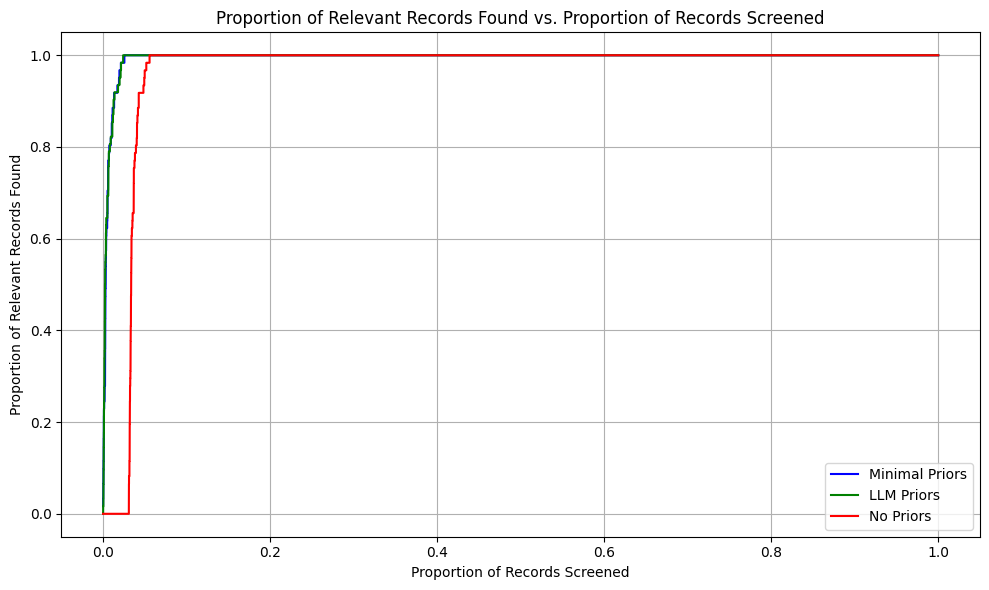

In [ ]:
# generate a plot with scaled cumulative sum (divided by total number of relevant records in dataset)
plt.figure(figsize=(10, 6))
plt.step(np.arange(1, len(df_cumsum['Minimal Priors'].dropna())+1) / len(df_cumsum['Minimal Priors'].dropna()), (df_cumsum['Minimal Priors'] / (dataset['label_included'].sum() - dataset['label_included'].iloc[minimal_prior_idx].sum())).dropna(), label='Minimal Priors', color='blue', where='post')
plt.step(np.arange(1, len(df_cumsum['LLM Priors'].dropna())+1) / len(df_cumsum['LLM Priors'].dropna()), (df_cumsum['LLM Priors'] / dataset['label_included'].sum()).dropna(), label='LLM Priors', color='green', where='post')
plt.step(np.arange(1, len(df_cumsum['No Priors'].dropna())+1) / len(df_cumsum['No Priors'].dropna()), (df_cumsum['No Priors'] / (dataset['label_included'].sum() - dataset['label_included'].iloc[priors_from_random_search].sum())).dropna(), label='No Priors', color='red', where='post')
plt.xlabel('Proportion of Records Screened')
plt.ylabel('Proportion of Relevant Records Found')
plt.title('Proportion of Relevant Records Found vs. Proportion of Records Screened')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# save plot to output_path
plot_path = Path.Path(output_path) / f'{name_dataset}_simulation_plot.png'
plt.savefig(plot_path)

### Metrics

In [ ]:
# calculate the area under the curve (AUC) for each method
auc_minimal = np.trapezoid((df_cumsum['Minimal Priors'] / (dataset['label_included'].sum() - dataset['label_included'].iloc[minimal_prior_idx].sum())).dropna(), np.arange(1, len(df_cumsum['Minimal Priors'].dropna())+1) / len(df_cumsum['Minimal Priors'].dropna()))
auc_llm = np.trapezoid((df_cumsum['LLM Priors'] / dataset['label_included'].sum()).dropna(), np.arange(1, len(df_cumsum['LLM Priors'].dropna())+1) / len(df_cumsum['LLM Priors'].dropna()))
auc_no_priors = np.trapezoid((df_cumsum['No Priors'] / (dataset['label_included'].sum() - dataset['label_included'].iloc[priors_from_random_search].sum())).dropna(), np.arange(1, len(df_cumsum['No Priors'].dropna())+1) / len(df_cumsum['No Priors'].dropna()))
auc_minimal, auc_llm, auc_no_priors

#correct? (AI: generated currently)